In [2]:
import numpy as np
import tifffile
from scipy import stats
from scipy import ndimage
from skimage import filters
from skimage import feature
import matplotlib.pyplot as plt
from skimage.util import view_as_windows
import warnings
warnings.filterwarnings('ignore')

class FluorescenceNoiseAnalyzer:
    """
    A class to analyze noise in fluorescence microscopy images.
    Implements multiple noise analysis methods specifically tailored for fluorescence microscopy.
    """

    def __init__(self, image_path):
        """Initialize with an image path and load the image."""
        self.image = tifffile.imread(image_path)
        self.image_float = self.image.astype(float)

    def estimate_background(self, method='adaptive', block_size=51, offset=10):
        """
        Improved background estimation with multiple methods.

        Parameters:
        - method: 'adaptive', 'percentile', or 'rolling_ball'
        - block_size: size of local neighborhood for adaptive method
        - offset: sensitivity adjustment
        """
        if method == 'adaptive':
            # Use adaptive thresholding with larger window
            thresh = filters.threshold_local(self.image, block_size, offset=offset)
            self.background_mask = self.image < thresh

        elif method == 'percentile':
            # Use a percentile-based approach
            thresh = np.percentile(self.image, 10)  # bottom 10% as background
            self.background_mask = self.image < thresh

        elif method == 'rolling_ball':
            # Rolling ball algorithm (common in microscopy)
            from skimage.morphology import rolling_ball
            background = rolling_ball(self.image, radius=50)
            self.background_mask = self.image < (background + offset)

        self.background_pixels = self.image_float[self.background_mask]
        return self.background_mask

    def calculate_basic_statistics(self):
        """
        Calculate basic statistical measures of noise.
        Returns SNR and background statistics.
        """
        # Calculate global statistics
        global_mean = np.mean(self.image_float)
        global_std = np.std(self.image_float)

        # Calculate background statistics
        bg_mean = np.mean(self.background_pixels)
        bg_std = np.std(self.background_pixels)

        # Calculate signal region (non-background) statistics
        signal_mask = ~self.background_mask
        signal_pixels = self.image_float[signal_mask]
        signal_mean = np.mean(signal_pixels)

        # Calculate Signal-to-Noise Ratio
        snr = (signal_mean - bg_mean) / bg_std if bg_std != 0 else float('inf')

        return {
            'global_mean': global_mean,
            'global_std': global_std,
            'background_mean': bg_mean,
            'background_std': bg_std,
            'signal_mean': signal_mean,
            'snr': snr
        }

    def analyze_noise_distribution(self):
        """
        Analyze the statistical distribution of noise in the background.
        For fluorescence microscopy, we expect a mixture of Poisson (from photon detection)
        and Gaussian noise (from detector electronics).
        """
        # For Poisson noise analysis
        # Instead of fitting, we estimate lambda parameter as the mean
        # This works because for Poisson distribution, mean = variance = lambda
        poisson_lambda = np.mean(self.background_pixels)

        # Generate theoretical Poisson distribution with this lambda
        # We need to use integers for Poisson
        background_ints = self.background_pixels.astype(int)
        poisson_ks_stat, poisson_p_value = stats.kstest(
            background_ints,
            lambda x: stats.poisson.cdf(x, poisson_lambda)
        )

        # For Gaussian noise (from detector)
        # We can use fit here because Gaussian is a continuous distribution
        gaussian_params = stats.norm.fit(self.background_pixels)
        gaussian_ks_stat, gaussian_p_value = stats.kstest(
            self.background_pixels,
            'norm',
            gaussian_params
        )

        return {
            'poisson_fit': {
                'lambda': poisson_lambda,
                'ks_statistic': poisson_ks_stat,
                'p_value': poisson_p_value
            },
            'gaussian_fit': {
                'params': gaussian_params,
                'ks_statistic': gaussian_ks_stat,
                'p_value': gaussian_p_value
            }
        }

    def analyze_spatial_noise(self, patch_size=64):
        """
        Analyze how noise varies spatially across the image.
        Uses patch-based analysis.
        """
        # Create patches of the image
        patches = view_as_windows(self.image_float,
                                window_shape=(patch_size, patch_size),
                                step=patch_size)

        # Calculate local statistics for each patch
        local_means = np.mean(patches, axis=(2, 3))
        local_stds = np.std(patches, axis=(2, 3))

        # Calculate coefficient of variation for each patch
        local_cv = local_stds / local_means

        return {
            'local_means': local_means,
            'local_stds': local_stds,
            'local_cv': local_cv
        }

    def analyze_frequency_noise(self):
        """
        Analyze noise in the frequency domain.
        Useful for identifying periodic noise patterns.
        """
        # Compute 2D FFT
        fft = np.fft.fft2(self.image_float)
        fft_shifted = np.fft.fftshift(fft)
        power_spectrum = np.abs(fft_shifted)**2

        # Calculate radial profile of power spectrum
        center = np.array(power_spectrum.shape) // 2
        y, x = np.indices(power_spectrum.shape)
        r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
        r = r.astype(int)

        # Calculate the azimuthally averaged radial profile
        radial_prof = np.bincount(r.ravel(), power_spectrum.ravel())
        radial_prof /= np.bincount(r.ravel())

        return {
            'power_spectrum': power_spectrum,
            'radial_profile': radial_prof
        }

    def plot_analysis(self):
        """
        Create comprehensive visualization of noise analysis results.
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Original image
        axes[0, 0].imshow(self.image, cmap='gray')
        axes[0, 0].set_title('Original Image')

        # Background mask
        axes[0, 1].imshow(self.background_mask, cmap='gray')
        axes[0, 1].set_title('Background Mask')

        # Histogram of background pixels
        axes[0, 2].hist(self.background_pixels, bins=50, density=True)
        axes[0, 2].set_title('Background Intensity Distribution')

        # Power spectrum
        freq_results = self.analyze_frequency_noise()
        axes[1, 0].imshow(np.log10(freq_results['power_spectrum']), cmap='viridis')
        axes[1, 0].set_title('Power Spectrum (log scale)')

        # Radial profile of power spectrum
        axes[1, 1].plot(freq_results['radial_profile'])
        axes[1, 1].set_title('Radial Power Spectrum Profile')
        axes[1, 1].set_yscale('log')

        # Spatial noise variation
        spatial_results = self.analyze_spatial_noise()
        im = axes[1, 2].imshow(spatial_results['local_cv'], cmap='viridis')
        axes[1, 2].set_title('Local Coefficient of Variation')
        plt.colorbar(im, ax=axes[1, 2])

        plt.tight_layout()
        return fig

def analyze_fluorescence_image(image_path):
    """
    Perform complete noise analysis on a fluorescence microscopy image.
    """
    analyzer = FluorescenceNoiseAnalyzer(image_path)

    # Perform analysis steps
    analyzer.estimate_background()
    basic_stats = analyzer.calculate_basic_statistics()
    dist_analysis = analyzer.analyze_noise_distribution()
    spatial_analysis = analyzer.analyze_spatial_noise()
    freq_analysis = analyzer.analyze_frequency_noise()

    # Print summary
    print("=== Noise Analysis Summary ===")
    print(f"\nBasic Statistics:")
    print(f"Signal-to-Noise Ratio: {basic_stats['snr']:.2f}")
    print(f"Background Standard Deviation: {basic_stats['background_std']:.2f}")

    print("\nNoise Distribution Analysis:")
    print("Poisson fit p-value:", dist_analysis['poisson_fit']['p_value'])
    print("Gaussian fit p-value:", dist_analysis['gaussian_fit']['p_value'])

    # Create visualization
    fig = analyzer.plot_analysis()

    return {
        'basic_stats': basic_stats,
        'distribution_analysis': dist_analysis,
        'spatial_analysis': spatial_analysis,
        'frequency_analysis': freq_analysis,
        'figure': fig
    }

=== Noise Analysis Summary ===

Basic Statistics:
Signal-to-Noise Ratio: -0.30
Background Standard Deviation: 43.74

Noise Distribution Analysis:
Poisson fit p-value: 0.0
Gaussian fit p-value: 0.0


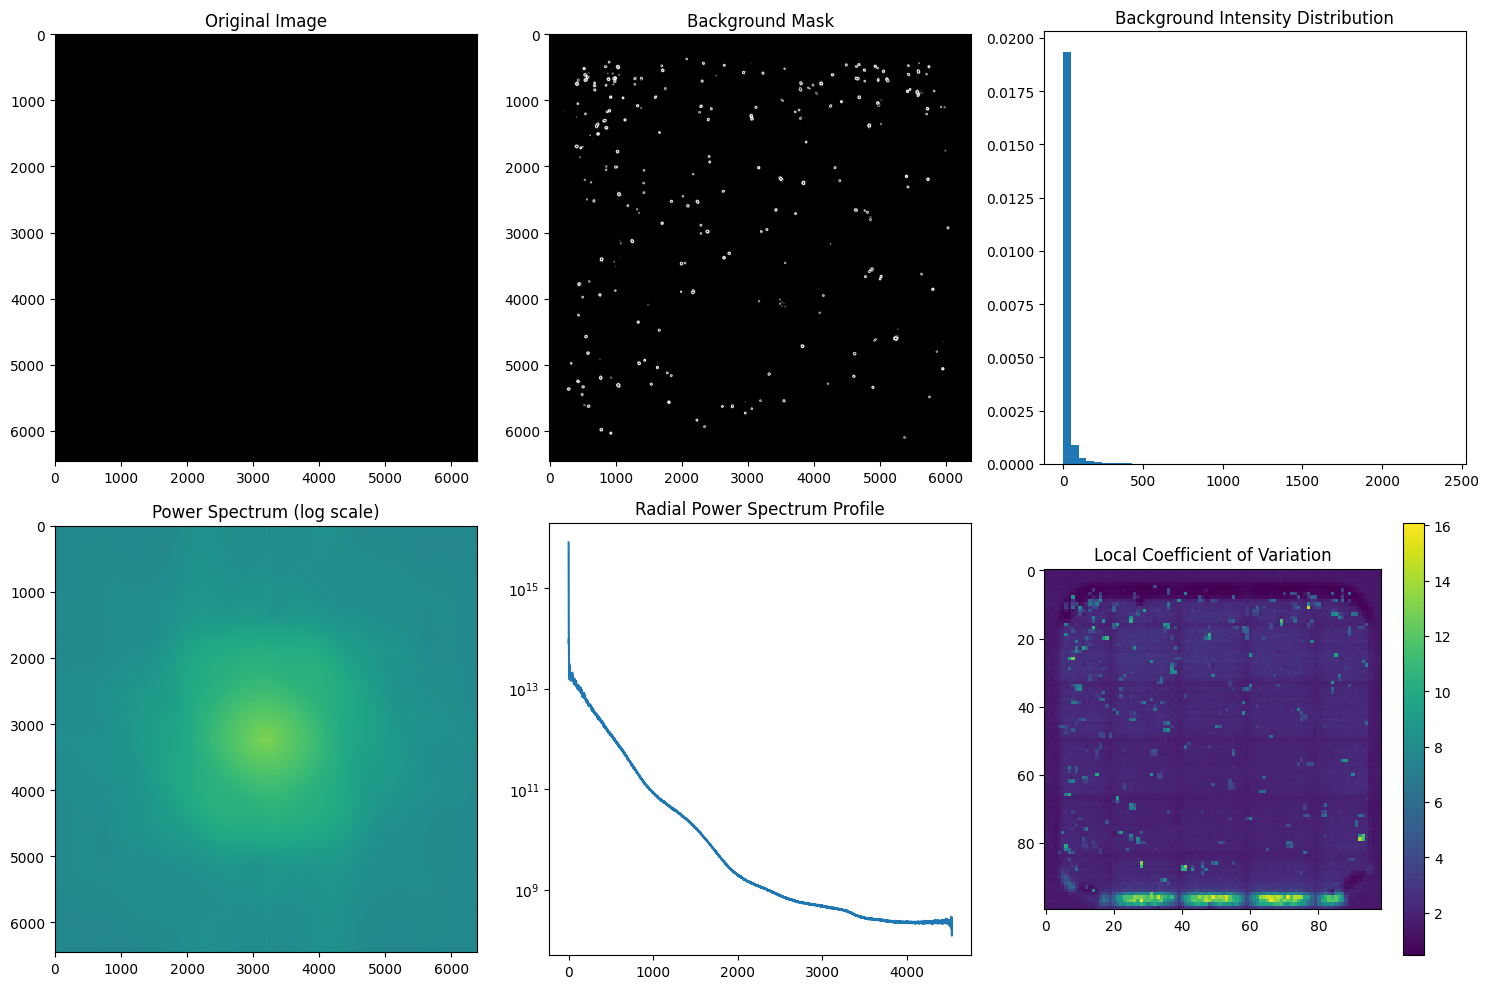

In [3]:
# Analyze a single image
image_path = '../../EXP2111_A06_D#07_T0003_C01.tif'
results = analyze_fluorescence_image(image_path)

# Display the results
plt.show()

In [4]:
import numpy as np
from scipy import fftpack, stats
from skimage import io, exposure
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from skimage.util import view_as_windows

def analyze_light_intensity(image_path):
    """
    Analyze light intensity in microscopy images with multiple visualization methods.

    Parameters:
    image_path (str): Path to the TIFF image file

    Returns:
    tuple: (metrics dictionary, matplotlib figure)
    """
    # Read and preprocess the image
    img = io.imread(image_path)
    if img.ndim > 2:
        img = img.mean(axis=2)
    img_float = img.astype(float)

    # FFT analysis
    fft2 = fftpack.fft2(img)
    fft2_shifted = fftpack.fftshift(fft2)
    magnitude_spectrum = np.abs(fft2_shifted)

    # Analyze horizontal and vertical components
    center_y, center_x = magnitude_spectrum.shape[0]//2, magnitude_spectrum.shape[1]//2
    horizontal_profile = magnitude_spectrum[center_y, :]
    vertical_profile = magnitude_spectrum[:, center_x]

    h_peaks, _ = find_peaks(horizontal_profile, distance=20)
    v_peaks, _ = find_peaks(vertical_profile, distance=20)

    # Calculate noise characteristics
    window_size = 16  # Single window size for simplicity
    smoothed = gaussian_filter(img, sigma=window_size/4)

    local_std = np.zeros_like(img, dtype=float)
    local_mean = np.zeros_like(img, dtype=float)

    for i in range(0, img.shape[0]-window_size, window_size//2):
        for j in range(0, img.shape[1]-window_size, window_size//2):
            window = img[i:i+window_size, j:j+window_size]
            local_std[i:i+window_size, j:j+window_size] = np.std(window)
            local_mean[i:i+window_size, j:j+window_size] = np.mean(window)

    # Calculate coefficient of variation
    patches = view_as_windows(img_float,
                            window_shape=(64, 64),
                            step=64)
    local_means = np.mean(patches, axis=(2, 3))
    local_stds = np.std(patches, axis=(2, 3))
    local_cv = local_stds / local_means

    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

    # Original image with enhanced contrast
    ax1.imshow(exposure.equalize_hist(img), cmap='gray')
    ax1.set_title('Original Image (Enhanced Contrast)')

    # FFT magnitude spectrum
    log_spectrum = np.log(1 + magnitude_spectrum)
    ax2.imshow(log_spectrum, cmap='gray')
    ax2.axhline(y=center_y, color='r', alpha=0.3)
    ax2.axvline(x=center_x, color='r', alpha=0.3)
    ax2.set_title('FFT Magnitude Spectrum with Frequency Profiles')

    # Noise characteristics
    valid_pixels = (local_mean != 0) & (local_std != 0)
    ax3.scatter(local_mean[valid_pixels], local_std[valid_pixels],
               alpha=0.1, label='Measured')

    # Add theoretical Poisson curve
    x_range = np.linspace(0, np.max(local_mean[valid_pixels]), 100)
    ax3.plot(x_range, np.sqrt(x_range), 'r-', label='Theoretical Poisson')
    ax3.set_xlabel('Local Mean Intensity')
    ax3.set_ylabel('Local Standard Deviation')
    ax3.set_title('Noise Characteristics vs Theoretical Poisson')
    ax3.legend()

    # Coefficient of variation
    im4 = ax4.imshow(local_cv, cmap='viridis')
    plt.colorbar(im4, ax=ax4)
    ax4.set_title('Local Coefficient of Variation')

    plt.tight_layout()

    # Calculate metrics
    metrics = {
        'horizontal_band_strengths': horizontal_profile[h_peaks].tolist(),
        'vertical_band_strengths': vertical_profile[v_peaks].tolist(),
        'mean_intensity': np.mean(img_float),
        'std_intensity': np.std(img_float),
        'mean_cv': np.mean(local_cv),
        'max_cv': np.max(local_cv),
        'intensity_range': (np.min(img_float), np.max(img_float)),
        'signal_to_noise': np.mean(img_float) / np.std(img_float) if np.std(img_float) != 0 else float('inf')
    }

    return metrics, fig

# Example usage
if __name__ == "__main__":
    metrics, fig = analyze_light_intensity('/Users/guidoputignano/PycharmProjects/Cellgroup_new/Cellgroup_up/EXP2111_A06_D#07_T0003_C01.tif')
    plt.show()

KeyboardInterrupt: 

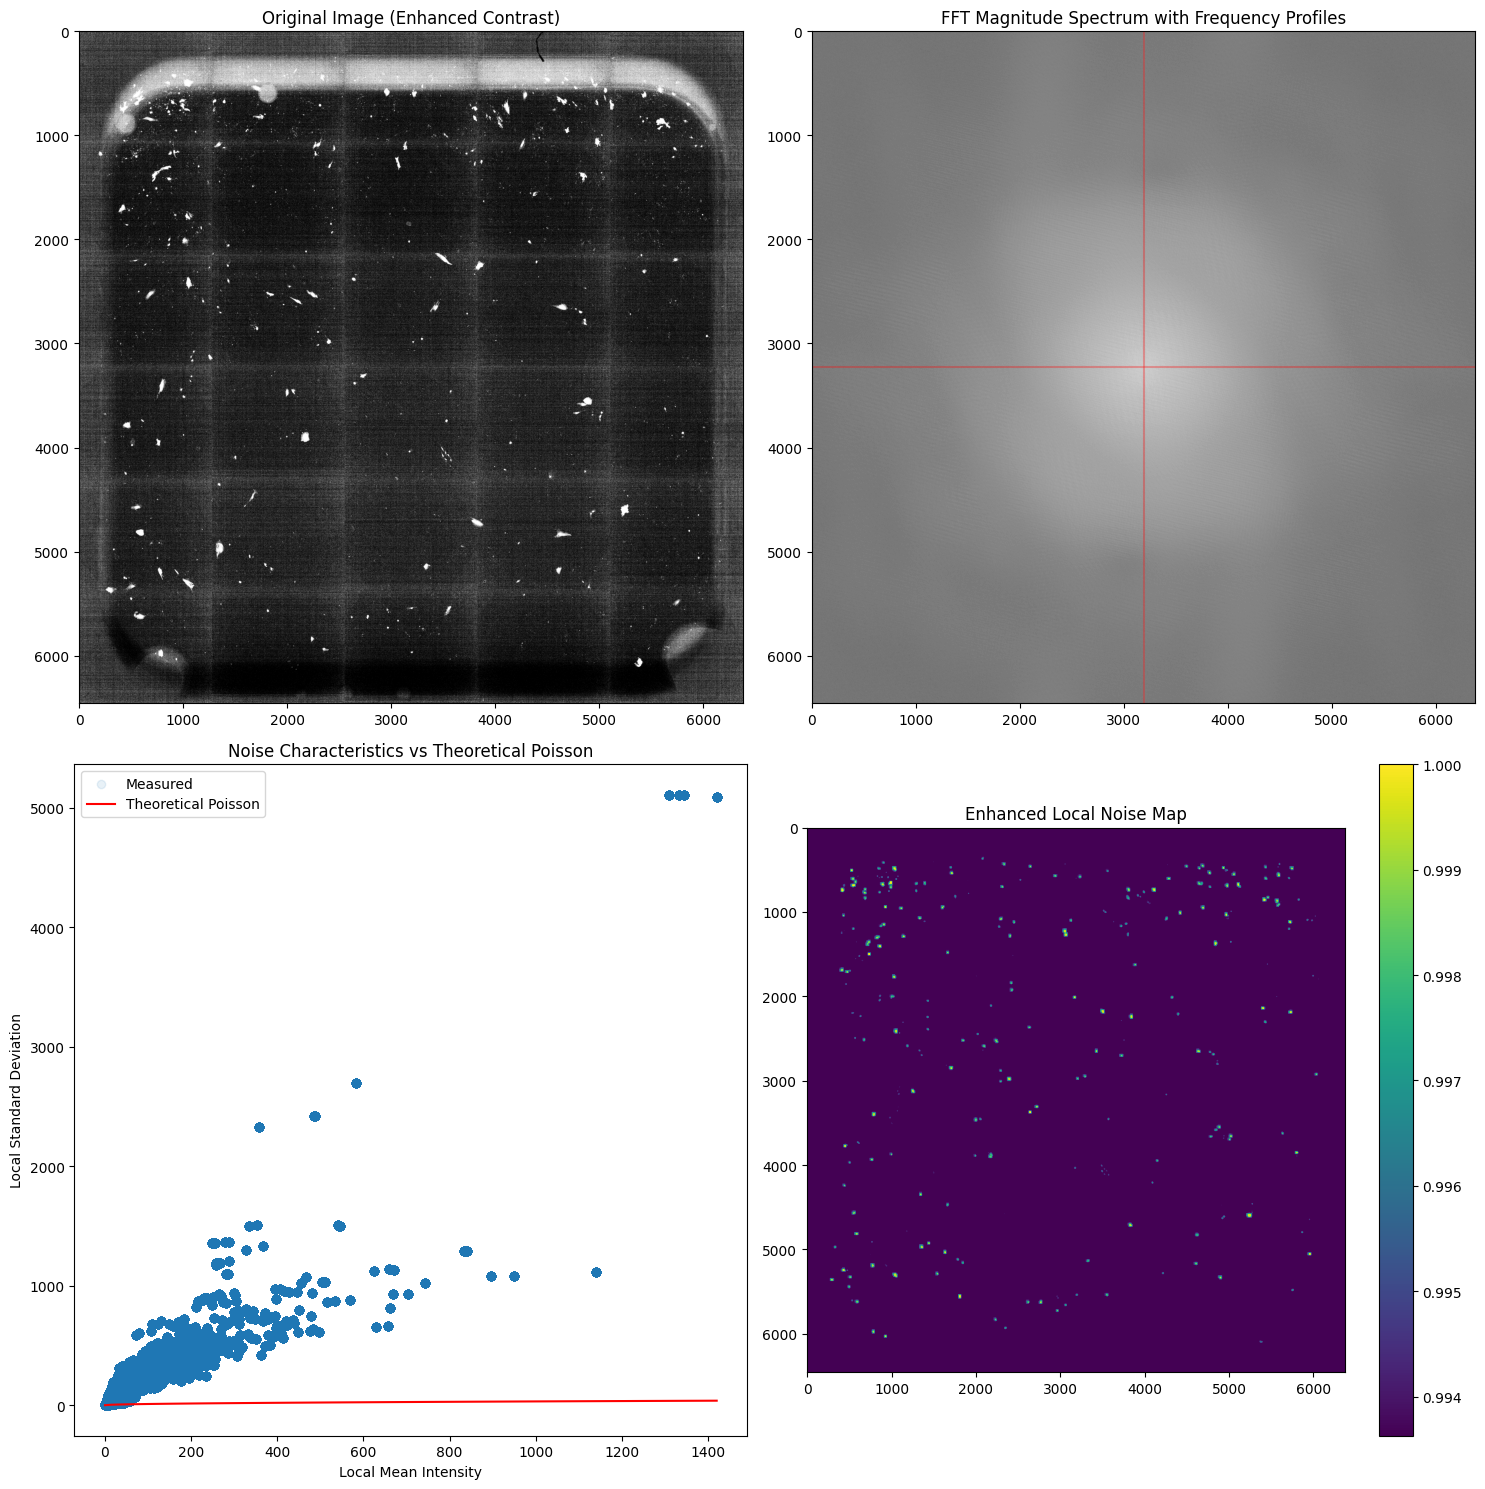

In [5]:
import numpy as np
from scipy import fftpack
from skimage import io, exposure
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def analyze_image_noise(image_path):
    """
    Enhanced analysis of banding and Poisson noise in microscopy images.

    Parameters:
    image_path (str): Path to the TIFF image file

    Returns:
    dict: Dictionary containing noise metrics
    """
    # Read the image
    img = io.imread(image_path)
    if img.ndim > 2:
        img = img.mean(axis=2)

    # 1. Enhanced FFT analysis
    fft2 = fftpack.fft2(img)
    fft2_shifted = fftpack.fftshift(fft2)
    magnitude_spectrum = np.abs(fft2_shifted)

    # Analyze horizontal and vertical frequency components separately
    center_y, center_x = magnitude_spectrum.shape[0]//2, magnitude_spectrum.shape[1]//2
    horizontal_profile = magnitude_spectrum[center_y, :]
    vertical_profile = magnitude_spectrum[:, center_x]

    # Find peaks in both directions
    h_peaks, _ = find_peaks(horizontal_profile, distance=20)
    v_peaks, _ = find_peaks(vertical_profile, distance=20)

    # 2. Enhanced Poisson noise analysis
    # Use multiple window sizes for multi-scale analysis
    window_sizes = [8, 16, 32]
    noise_maps = []

    for window_size in window_sizes:
        smoothed = gaussian_filter(img, sigma=window_size/4)
        noise = img - smoothed

        local_std = np.zeros_like(img, dtype=float)
        local_mean = np.zeros_like(img, dtype=float)

        for i in range(0, img.shape[0]-window_size, window_size//2):  # 50% overlap
            for j in range(0, img.shape[1]-window_size, window_size//2):
                window = img[i:i+window_size, j:j+window_size]
                local_std[i:i+window_size, j:j+window_size] = np.std(window)
                local_mean[i:i+window_size, j:j+window_size] = np.mean(window)

        noise_maps.append(local_std)

    # Combine noise maps using weighted average
    weights = [0.5, 0.3, 0.2]  # More weight to fine-scale noise
    combined_noise_map = np.zeros_like(noise_maps[0])
    for map, weight in zip(noise_maps, weights):
        combined_noise_map += map * weight

    # Enhance contrast of noise map
    noise_map_enhanced = exposure.equalize_hist(combined_noise_map)

    # Plot results with enhanced visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

    # Original image with enhanced contrast
    ax1.imshow(exposure.equalize_hist(img), cmap='gray')
    ax1.set_title('Original Image (Enhanced Contrast)')

    # FFT magnitude spectrum with peaks highlighted
    log_spectrum = np.log(1 + magnitude_spectrum)
    ax2.imshow(log_spectrum, cmap='gray')
    ax2.axhline(y=center_y, color='r', alpha=0.3)
    ax2.axvline(x=center_x, color='r', alpha=0.3)
    ax2.set_title('FFT Magnitude Spectrum with Frequency Profiles')

    # Noise characteristics with theoretical Poisson curve
    valid_pixels = (local_mean != 0) & (local_std != 0)
    ax3.scatter(local_mean[valid_pixels], local_std[valid_pixels], alpha=0.1, label='Measured')

    # Add theoretical Poisson curve
    x_range = np.linspace(0, np.max(local_mean[valid_pixels]), 100)
    ax3.plot(x_range, np.sqrt(x_range), 'r-', label='Theoretical Poisson')
    ax3.set_xlabel('Local Mean Intensity')
    ax3.set_ylabel('Local Standard Deviation')
    ax3.set_title('Noise Characteristics vs Theoretical Poisson')
    ax3.legend()

    # Enhanced noise map
    im4 = ax4.imshow(noise_map_enhanced, cmap='viridis')
    plt.colorbar(im4, ax=ax4)
    ax4.set_title('Enhanced Local Noise Map')

    plt.tight_layout()

    # Calculate enhanced metrics
    metrics = {
        'horizontal_band_strengths': horizontal_profile[h_peaks].tolist(),
        'vertical_band_strengths': vertical_profile[v_peaks].tolist(),
        'mean_noise_level': np.mean(combined_noise_map),
        'noise_std': np.std(combined_noise_map),
        'poisson_correlation': np.corrcoef(
            local_mean[valid_pixels],
            local_std[valid_pixels]
        )[0,1],
        'peak_noise_regions': np.percentile(combined_noise_map, 95)
    }

    return metrics, fig

metrics, fig = analyze_image_noise('/Users/guidoputignano/PycharmProjects/Cellgroup_new/Cellgroup_up/EXP2111_A06_D#07_T0003_C01.tif')
plt.show()

In [1]:
import tifffile
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

class MicroscopyNoiseAnalyzer:
    def __init__(self, image_path):
        """
        Initialize with a path to the TIFF file instead of an array.
        This gives us more direct control over image loading.
        """
        # Load and normalize image once to avoid repeated calculations
        self.original_image = tifffile.imread(image_path)
        self.image_float = self.original_image.astype(float)
        self._normalize_image()

    def _normalize_image(self):
        """Normalize image once during initialization"""
        img_min = self.image_float.min()
        img_max = self.image_float.max()
        self.normalized_image = (self.image_float - img_min) / (img_max - img_min)

    def analyze_all_noise(self, row_step=10, col_step=10, patch_size=50):
        """
        Comprehensive but efficient noise analysis.

        Parameters:
        row_step: Step size for sampling rows (higher = faster but less precise)
        col_step: Step size for sampling columns
        patch_size: Size of patches for local noise analysis
        """
        # Analyze grid pattern through sampling
        row_profile = np.mean(self.normalized_image[::row_step], axis=1)
        col_profile = np.mean(self.normalized_image[:,::col_step], axis=0)

        # Sample patches for random noise analysis
        patches = self.normalized_image[::patch_size, ::patch_size]
        noise_level = np.std(patches)

        # Calculate basic statistics efficiently
        signal_regions = self.normalized_image > np.percentile(self.normalized_image, 90)
        background_regions = self.normalized_image < np.percentile(self.normalized_image, 10)

        return {
            'grid_noise': {
                'row_variation': np.std(row_profile),
                'col_variation': np.std(col_profile),
                'profiles': (row_profile, col_profile)
            },
            'random_noise': {
                'level': noise_level,
                'distribution': patches.ravel()
            },
            'signal_stats': {
                'signal_mean': np.mean(self.normalized_image[signal_regions]),
                'background_mean': np.mean(self.normalized_image[background_regions]),
                'snr': (np.mean(self.normalized_image[signal_regions]) -
                       np.mean(self.normalized_image[background_regions])) / noise_level
            }
        }

    def plot_analysis(self):
        """Create visualizations of the noise analysis"""
        # Get all analysis results at once
        results = self.analyze_all_noise()

        fig, axes = plt.subplots(2, 2, figsize=(12, 12))

        # Original image
        axes[0,0].imshow(self.normalized_image, cmap='gray')
        axes[0,0].set_title('Normalized Image')

        # Grid pattern analysis
        axes[0,1].plot(results['grid_noise']['profiles'][0])
        axes[0,1].set_title(f"Row Variation: {results['grid_noise']['row_variation']:.3f}")

        axes[1,0].plot(results['grid_noise']['profiles'][1])
        axes[1,0].set_title(f"Column Variation: {results['grid_noise']['col_variation']:.3f}")

        # Noise distribution
        axes[1,1].hist(results['random_noise']['distribution'], bins=50)
        axes[1,1].set_title(f"Noise Level: {results['random_noise']['level']:.3f}")

        plt.tight_layout()
        return fig, results

# Simple usage example:
def analyze_microscopy_image(image_path):
    """Wrapper function for easy analysis of a single image"""
    analyzer = MicroscopyNoiseAnalyzer(image_path)
    fig, results = analyzer.plot_analysis()

    print("\nNoise Analysis Results:")
    print(f"Signal-to-Noise Ratio: {results['signal_stats']['snr']:.2f}")
    print(f"Grid Pattern Strength (Row): {results['grid_noise']['row_variation']:.3f}")
    print(f"Grid Pattern Strength (Col): {results['grid_noise']['col_variation']:.3f}")
    print(f"Random Noise Level: {results['random_noise']['level']:.3f}")

    return analyzer, fig, results

/Users/guidoputignano/python/Cellgroup_up/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/guidoputignano/python/Cellgroup_up/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Noise Analysis Results:
Signal-to-Noise Ratio: nan
Grid Pattern Strength (Row): 0.005
Grid Pattern Strength (Col): 0.004
Random Noise Level: 0.018


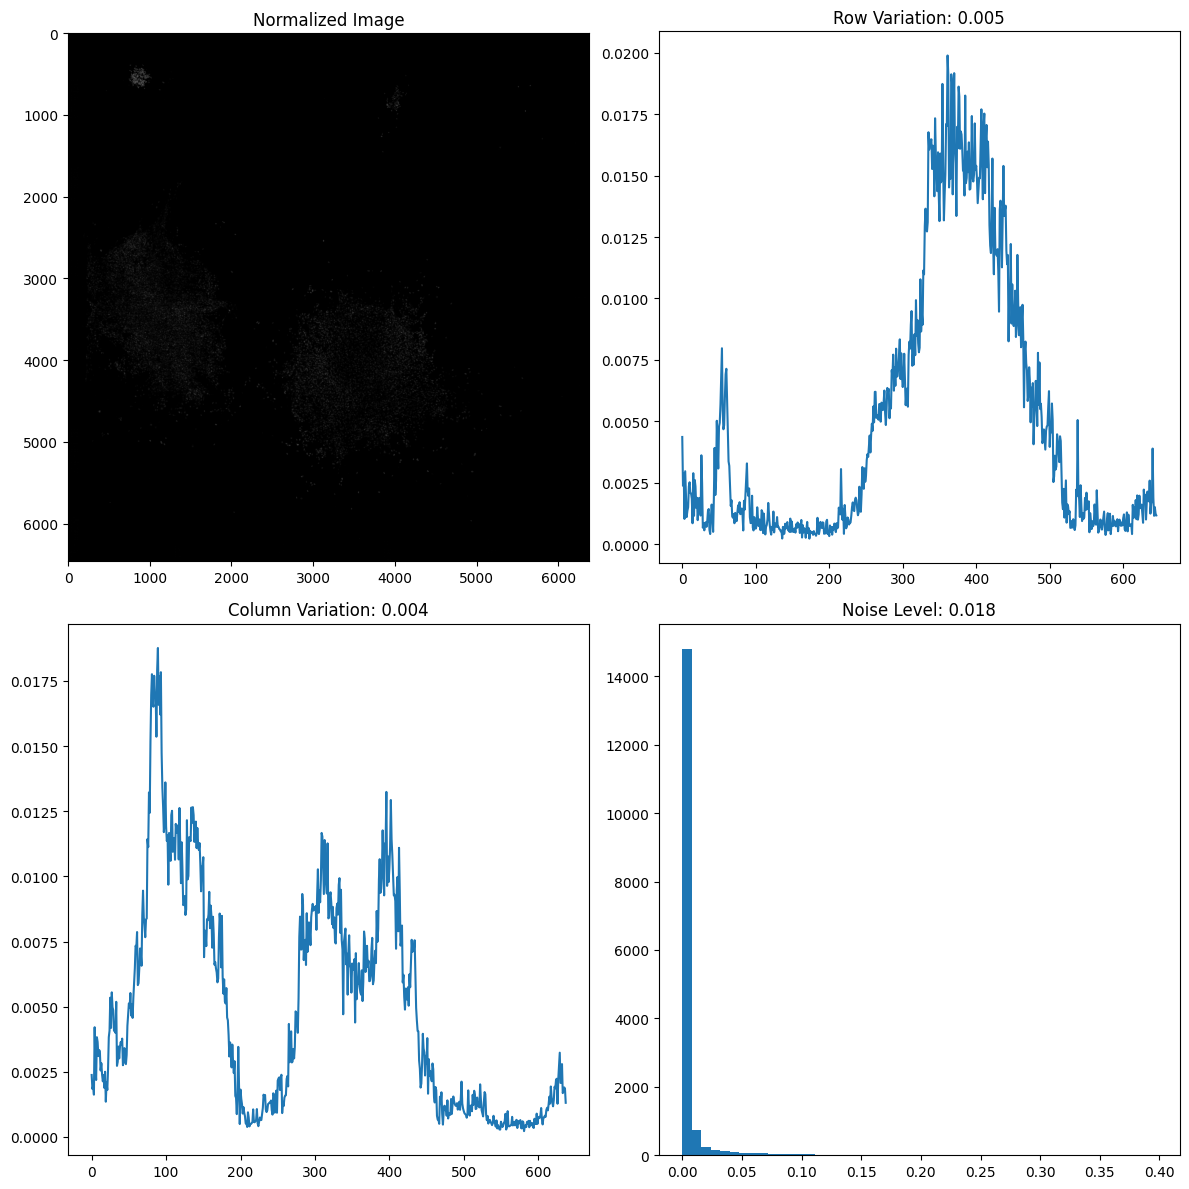

In [4]:
image_path = 'y/Users/guidoputignano/PycharmProjects/Cellgroup_new/Cellgroup_up/EXP2111_A06_D#07_T0003_C01.tif'
analyzer, fig, results = analyze_microscopy_image(image_path)
plt.show()

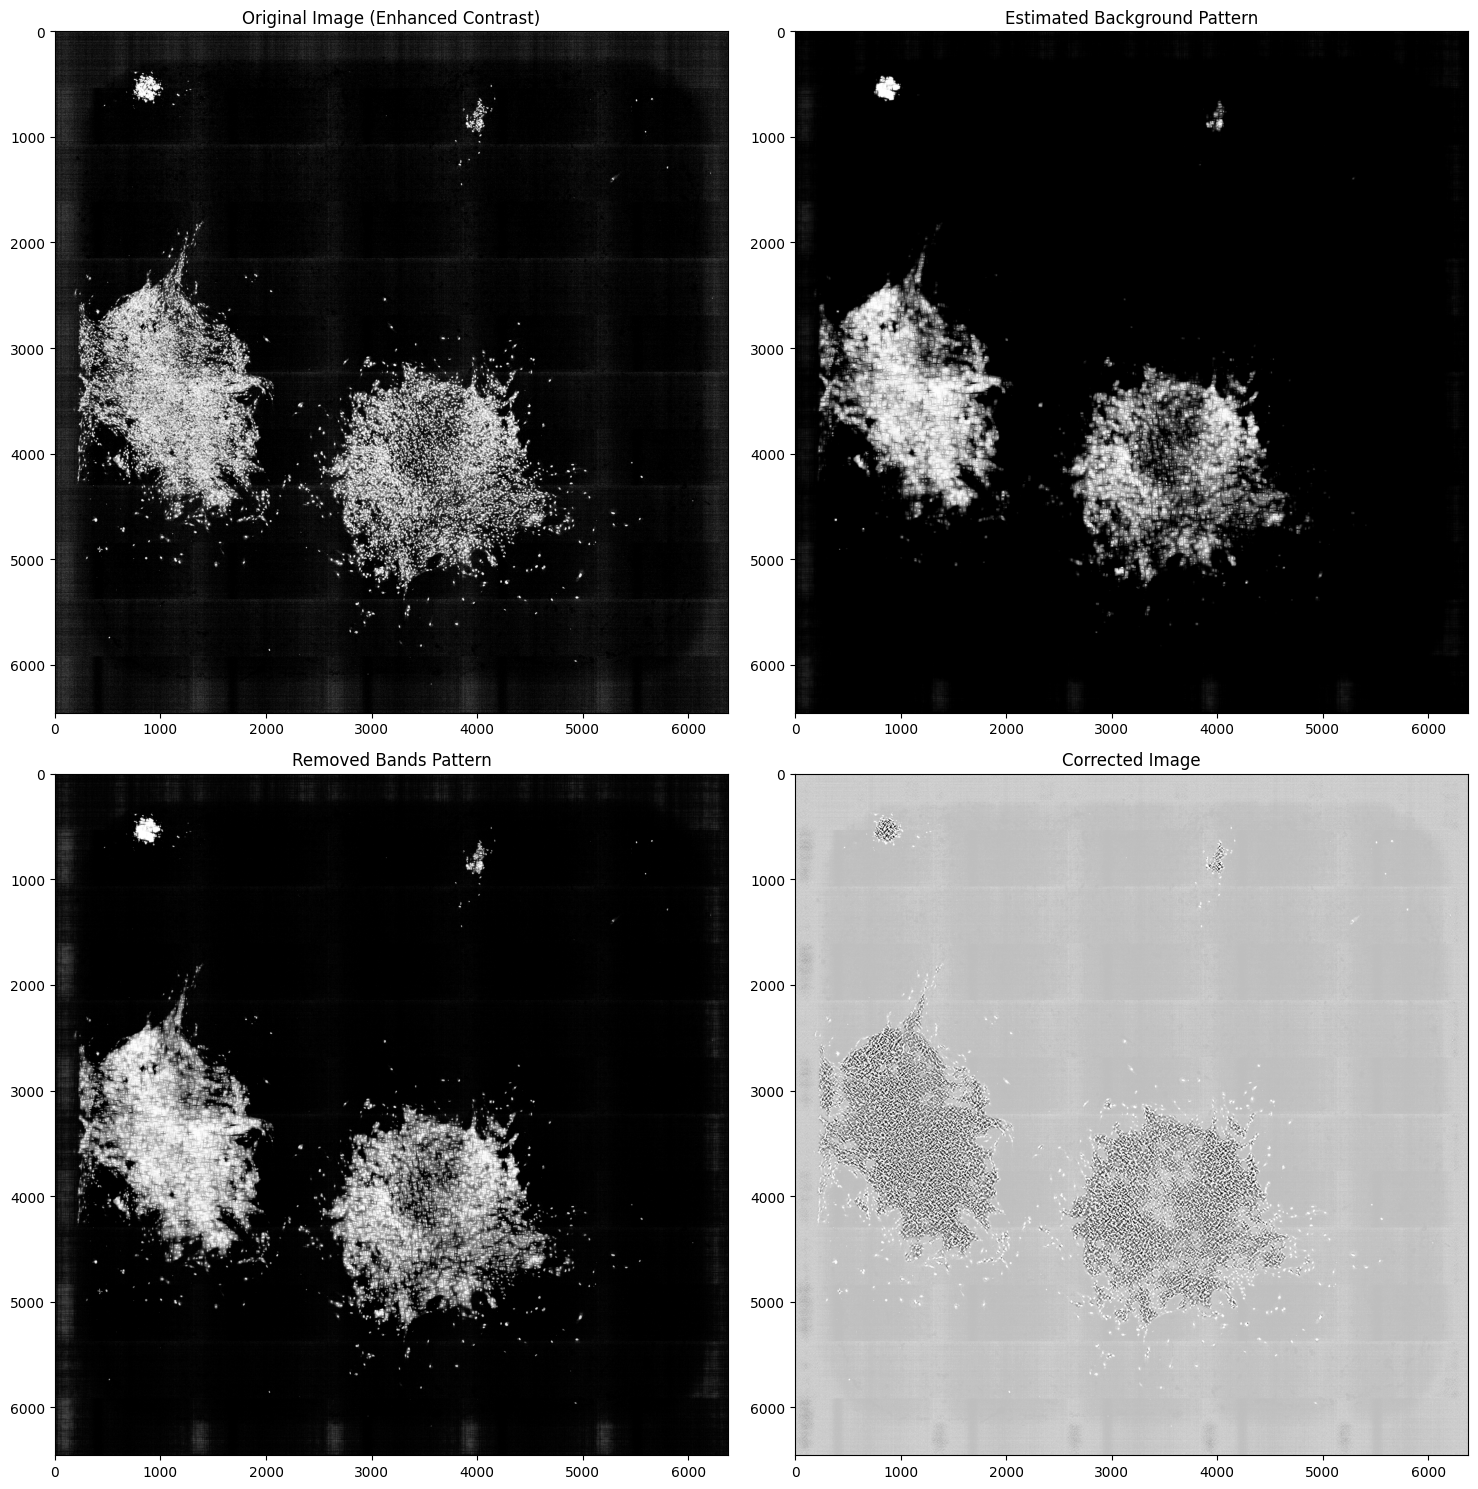

In [18]:
import numpy as np
from skimage import io, exposure
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt

def remove_directional_bands(img, filter_size=51):
    """
    Remove banding using directional median filtering.

    Parameters:
    img: 2D numpy array of the image
    filter_size: int, size of the median filter

    Returns:
    tuple: (cleaned image, bands removed)
    """
    # Create structure elements for horizontal and vertical directions
    h_size = (1, filter_size)  # horizontal window
    v_size = (filter_size, 1)  # vertical window

    # Apply median filters in both directions
    h_filtered = median_filter(img, size=h_size)
    v_filtered = median_filter(img, size=v_size)

    # Estimate local background as the minimum of both filtered images
    background = np.minimum(h_filtered, v_filtered)

    # Remove background and normalize
    img_corrected = img - background
    img_corrected = img_corrected - np.min(img_corrected)
    img_corrected = img_corrected / np.max(img_corrected)

    return img_corrected, background

def visualize_correction(image_path, filter_size=51):
    """
    Visualize the band removal process
    """
    # Read and prepare image
    img = io.imread(image_path)
    if img.ndim > 2:
        img = img.mean(axis=2)

    # Normalize input image
    img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Apply correction
    img_corrected, background = remove_directional_bands(img_norm, filter_size)

    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

    # Original image
    ax1.imshow(exposure.equalize_hist(img_norm), cmap='gray')
    ax1.set_title('Original Image (Enhanced Contrast)')

    # Background pattern
    ax2.imshow(exposure.equalize_hist(background), cmap='gray')
    ax2.set_title('Estimated Background Pattern')

    # Difference (bands)
    difference = img_norm - img_corrected
    ax3.imshow(exposure.equalize_hist(difference), cmap='gray')
    ax3.set_title('Removed Bands Pattern')

    # Corrected image
    ax4.imshow(exposure.equalize_hist(img_corrected), cmap='gray')
    ax4.set_title('Corrected Image')

    plt.tight_layout()
    return fig, img_corrected

# Example usage:
fig, cleaned_image = visualize_correction('/Users/guidoputignano/PycharmProjects/Cellgroup_new/Cellgroup_up/EXP2111_A06_D#19_T0007_C13.tif')
plt.show()

In [ ]:
import numpy as np
from skimage import io, exposure
from scipy.ndimage import median_filter, uniform_filter1d, generic_filter
import matplotlib.pyplot as plt

def local_std(img, size=25):
    """Calculate local standard deviation using a sliding window"""
    def std_filter(x):
        return np.std(x)
    return generic_filter(img, std_filter, size=size)

def remove_bands_selectively(img, band_width=50, threshold_factor=2):
    """
    Remove banding while preserving significant features.

    Parameters:
    img: 2D numpy array of the image
    band_width: int, expected width of the bands
    threshold_factor: float, controls feature preservation

    Returns:
    tuple: (cleaned image, background, bands)
    """
    # Normalize input image
    img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Detect significant features using local standard deviation
    local_std_map = local_std(img_norm, size=25)
    feature_mask = local_std_map > threshold_factor * np.mean(local_std_map)

    # Create a copy for background estimation
    img_for_bg = img_norm.copy()
    img_for_bg[feature_mask] = np.mean(img_norm[~feature_mask])

    # Estimate bands in horizontal and vertical directions
    h_bands = uniform_filter1d(img_for_bg, band_width, axis=0)
    v_bands = uniform_filter1d(img_for_bg, band_width, axis=1)

    # Combine band estimates
    background = np.minimum(h_bands, v_bands)

    # Remove background only where there are no significant features
    img_corrected = img_norm.copy()
    img_corrected[~feature_mask] = img_norm[~feature_mask] - background[~feature_mask]

    # Normalize output
    img_corrected = img_corrected - np.min(img_corrected)
    img_corrected = img_corrected / np.max(img_corrected)

    # Calculate removed bands
    bands = img_norm - img_corrected

    return img_corrected, background, bands

def visualize_selective_correction(image_path, band_width=50, threshold_factor=2):
    """
    Visualize the selective band removal process
    """
    # Read image
    img = io.imread(image_path)
    if img.ndim > 2:
        img = img.mean(axis=2)

    # Apply correction
    img_corrected, background, bands = remove_bands_selectively(
        img, band_width, threshold_factor
    )

    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

    # Original image
    ax1.imshow(exposure.equalize_hist(img), cmap='gray')
    ax1.set_title('Original Image (Enhanced Contrast)')

    # Background pattern
    ax2.imshow(background, cmap='gray')
    ax2.set_title('Estimated Band Pattern')

    # Removed bands
    ax3.imshow(exposure.equalize_hist(bands), cmap='gray')
    ax3.set_title('Removed Bands')

    # Corrected image
    ax4.imshow(exposure.equalize_hist(img_corrected), cmap='gray')
    ax4.set_title('Corrected Image')

    plt.tight_layout()
    return fig, img_corrected


# Example usage:
fig, cleaned_image = visualize_selective_correction('/Users/guidoputignano/PycharmProjects/Cellgroup_new/Cellgroup_up/EXP2111_A06_D#07_T0003_C01.tif')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8e186db4c0>>
Traceback (most recent call last):
  File "/Users/guidoputignano/python/Cellgroup_up/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8e186db4c0>>
Traceback (most recent call last):
  File "/Users/guidoputignano/python/Cellgroup_up/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Running directional analyses...


/Users/guidoputignano/python/Cellgroup_up/lib/python3.8/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '



Radon Analysis:
Dominant angle: 93.5°
Strength: 0.189

Directional Variance Analysis:
Dominant angle: 180.0°
Strength: 0.000

Gradient Analysis:
Dominant angle: 0.0°
Average gradient magnitude: 0.000

Gabor Filter Analysis:
Dominant angle: 0.0°
Maximum response: 0.001


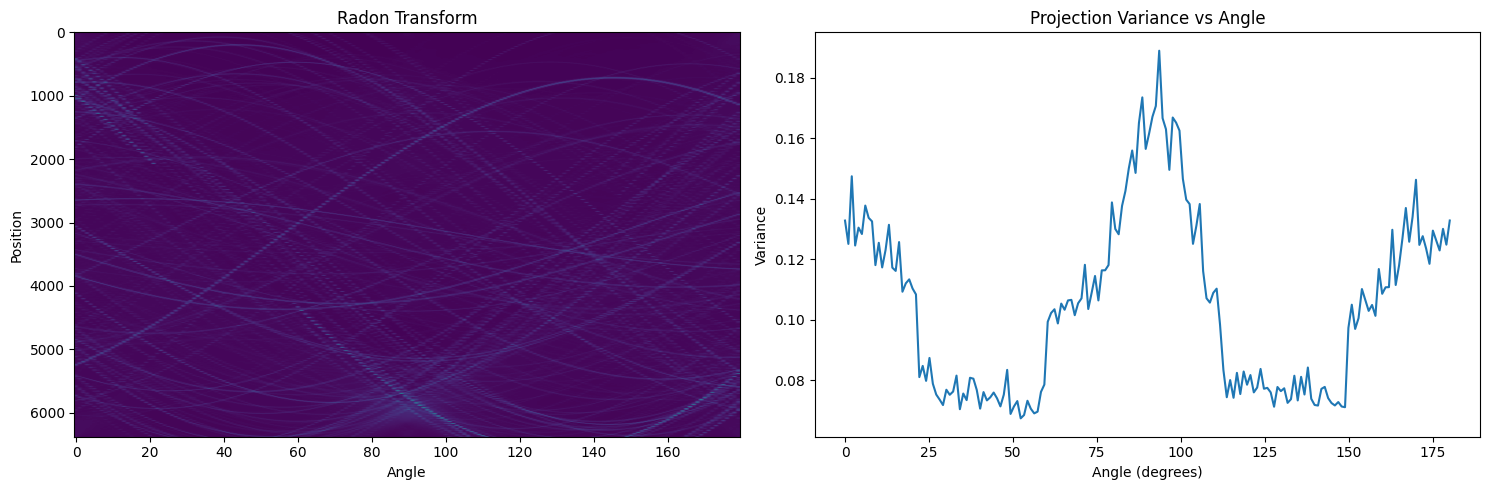

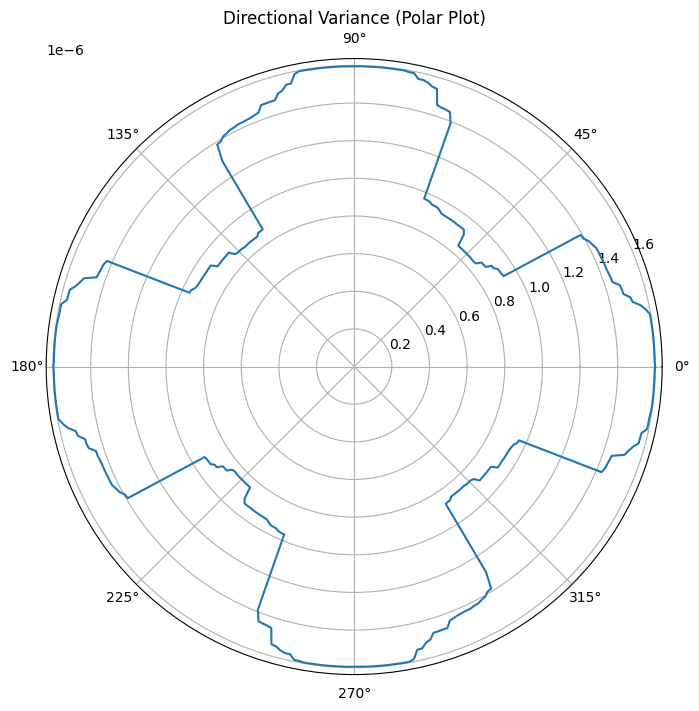

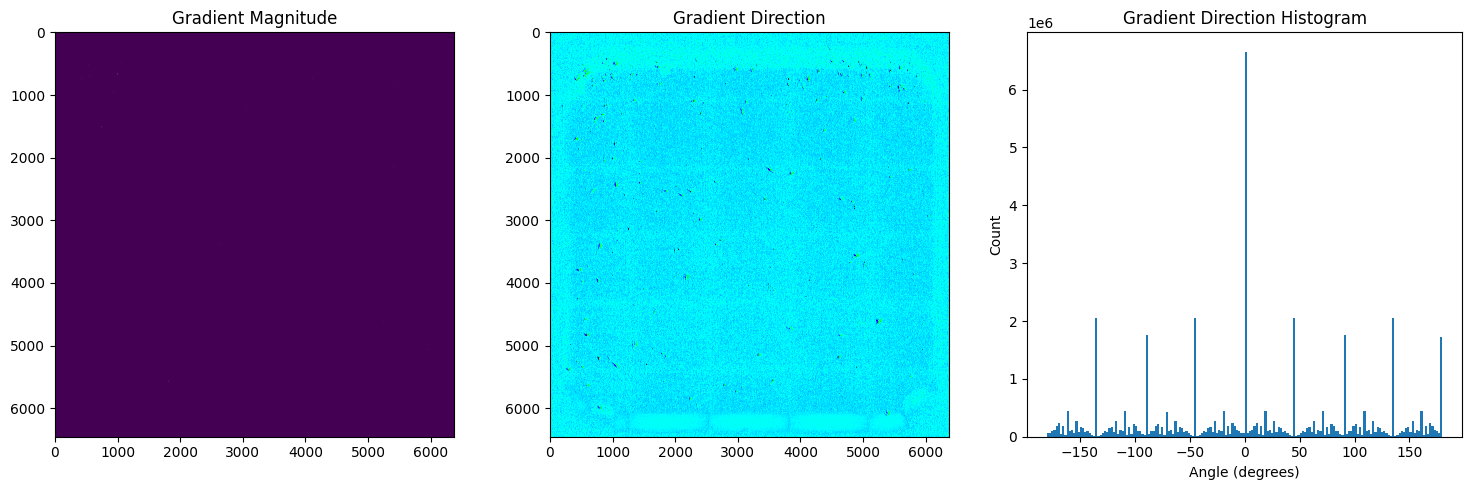

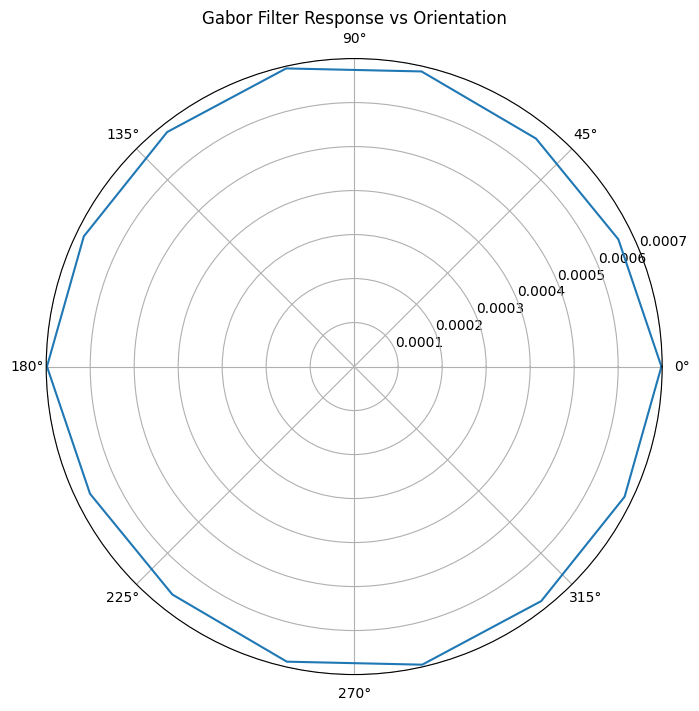

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from skimage.transform import radon
from scipy import ndimage

def create_gabor_kernel(sigma, theta, frequency, phase=0):
    """Create a Gabor kernel with given parameters."""
    sigma_x = sigma
    sigma_y = sigma

    # Bounding box
    nstds = 3  # Number of standard deviations
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))

    # Create kernel coords
    x = np.linspace(-xmax, xmax, int(2 * xmax + 1))
    y = np.linspace(-ymax, ymax, int(2 * ymax + 1))
    y, x = np.meshgrid(y, x)

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    # Kernel calculation
    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * \
         np.cos(2 * np.pi * frequency * x_theta + phase)

    return gb

def analyze_directional_noise(image_path):
    # Read and convert image to float
    img = io.imread(image_path)
    img = img.astype(float) / img.max()  # Normalize to 0-1

    # 1. Radon Transform Analysis
    def radon_analysis(img):
        theta = np.linspace(0., 180., 180)
        sinogram = radon(img, theta=theta)

        # Analyze variance in each projection
        projection_variance = np.var(sinogram, axis=0)

        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        plt.imshow(sinogram, cmap='viridis', aspect='auto')
        plt.title('Radon Transform')
        plt.xlabel('Angle')
        plt.ylabel('Position')

        plt.subplot(122)
        plt.plot(theta, projection_variance)
        plt.title('Projection Variance vs Angle')
        plt.xlabel('Angle (degrees)')
        plt.ylabel('Variance')
        plt.tight_layout()

        # Return angle with maximum variance
        max_angle = theta[np.argmax(projection_variance)]
        return max_angle, np.max(projection_variance)

    # 2. Directional Variance Analysis
    def directional_variance(img, num_angles=180):
        angles = np.linspace(0, 180, num_angles)
        variances = []

        for angle in angles:
            # Rotate image
            rotated = ndimage.rotate(img, angle, reshape=False)
            # Calculate variance along columns (perpendicular to rotation)
            var = np.var(rotated, axis=0).mean()
            variances.append(var)

        # Plot polar representation
        plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, projection='polar')
        # Plot twice to complete the circle
        angles_rad = np.deg2rad(np.concatenate([angles, angles + 180]))
        variances_full = np.concatenate([variances, variances])
        ax.plot(angles_rad, variances_full)
        plt.title('Directional Variance (Polar Plot)')

        return angles[np.argmax(variances)], np.max(variances)

    # 3. Oriented Gradient Analysis
    def gradient_analysis(img):
        # Calculate gradients
        gradient_x = ndimage.sobel(img, axis=0)
        gradient_y = ndimage.sobel(img, axis=1)

        # Calculate gradient magnitude and direction
        magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
        direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi

        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(magnitude, cmap='viridis')
        plt.title('Gradient Magnitude')

        plt.subplot(132)
        plt.imshow(direction, cmap='hsv')
        plt.title('Gradient Direction')

        plt.subplot(133)
        plt.hist(direction.ravel(), bins=180, range=(-180, 180))
        plt.title('Gradient Direction Histogram')
        plt.xlabel('Angle (degrees)')
        plt.ylabel('Count')
        plt.tight_layout()

        return np.median(direction), np.mean(magnitude)

    # 4. Custom Gabor Filter Analysis
    def gabor_analysis(img, num_angles=8):
        angles = np.linspace(0, np.pi, num_angles)
        responses = []

        # Generate Gabor filters at different orientations
        sigma = 4.0  # Filter size parameter
        frequency = 0.1  # Spatial frequency of the filter
        kernels = [create_gabor_kernel(sigma, theta, frequency) for theta in angles]

        # Apply filters and measure response
        for kernel in kernels:
            filtered = np.abs(ndimage.convolve(img, kernel))
            responses.append(np.mean(filtered))

        plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, projection='polar')
        # Plot twice to complete the circle
        angles_full = np.concatenate([angles, angles + np.pi])
        responses_full = np.concatenate([responses, responses])
        ax.plot(angles_full, responses_full)
        plt.title('Gabor Filter Response vs Orientation')

        return angles[np.argmax(responses)] * 180 / np.pi, np.max(responses)

    # Run all analyses
    print("Running directional analyses...")

    radon_angle, radon_strength = radon_analysis(img)
    print(f"\nRadon Analysis:")
    print(f"Dominant angle: {radon_angle:.1f}°")
    print(f"Strength: {radon_strength:.3f}")

    var_angle, var_strength = directional_variance(img)
    print(f"\nDirectional Variance Analysis:")
    print(f"Dominant angle: {var_angle:.1f}°")
    print(f"Strength: {var_strength:.3f}")

    grad_angle, grad_strength = gradient_analysis(img)
    print(f"\nGradient Analysis:")
    print(f"Dominant angle: {grad_angle:.1f}°")
    print(f"Average gradient magnitude: {grad_strength:.3f}")

    gabor_angle, gabor_strength = gabor_analysis(img)
    print(f"\nGabor Filter Analysis:")
    print(f"Dominant angle: {gabor_angle:.1f}°")
    print(f"Maximum response: {gabor_strength:.3f}")

    plt.show()

    return {
        'radon': (radon_angle, radon_strength),
        'variance': (var_angle, var_strength),
        'gradient': (grad_angle, grad_strength),
        'gabor': (gabor_angle, gabor_strength)
    }

# Usage:
results = analyze_directional_noise('/Users/guidoputignano/PycharmProjects/Cellgroup_new/Cellgroup_up/EXP2111_A06_D#07_T0003_C01.tif')

Starting analysis...

Running individual analyses...


/Users/guidoputignano/python/Cellgroup_up/lib/python3.8/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


radon_analysis execution time: 166.29 seconds
directional_variance execution time: 1082.78 seconds
gradient_analysis execution time: 3.58 seconds
gabor_analysis execution time: 165.62 seconds

Results Summary:
Radon Analysis:
  Dominant angle: 49.3°
  Strength: 18263.236

Directional Variance Analysis:
  Dominant angle: 137.8°
  Strength: 0.001

Gradient Analysis:
  Dominant angle: 0.0°
  Average gradient magnitude: 0.014

Gabor Filter Analysis:
  Dominant angle: 0.0°
  Maximum response: 0.441

Total execution time: 1418.52 seconds


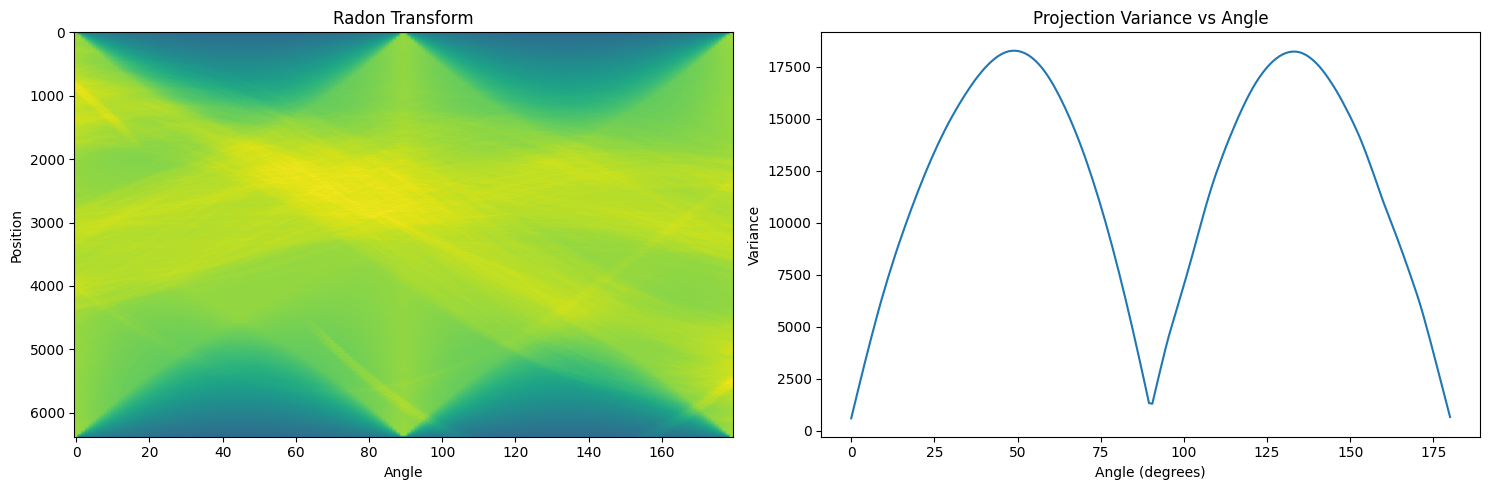

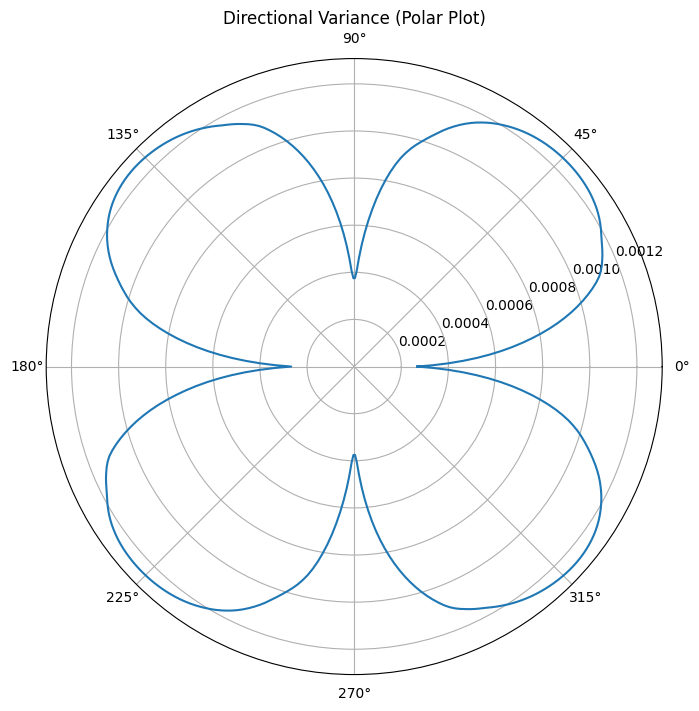

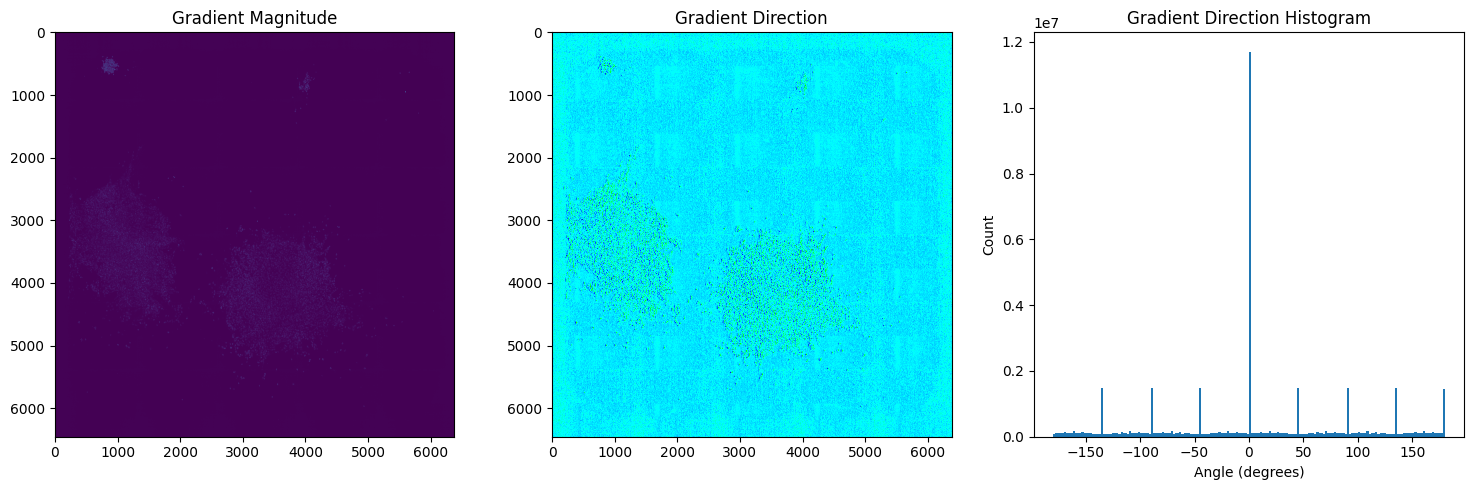

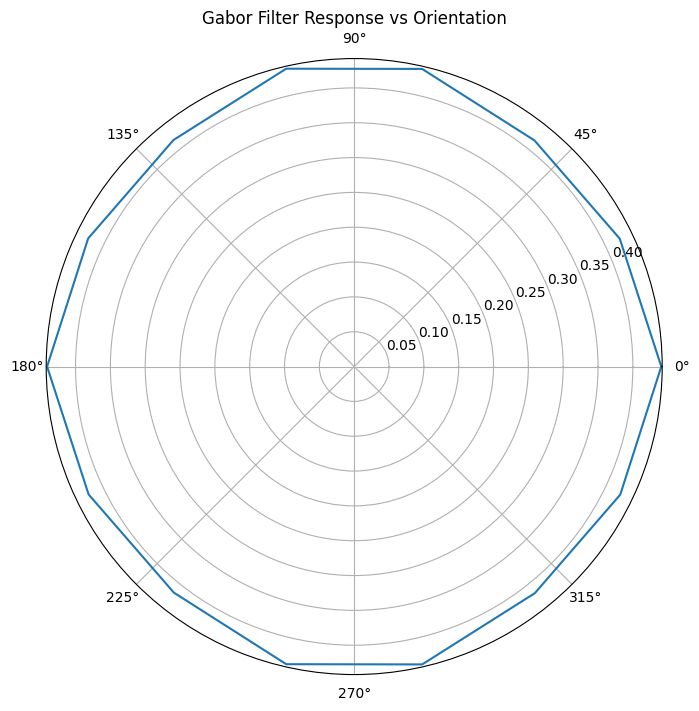

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from skimage.transform import radon
from scipy import ndimage
import time
from functools import wraps

def timer_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"{func.__name__} execution time: {execution_time:.2f} seconds")
        return result, execution_time
    return wrapper

def create_gabor_kernel(sigma, theta, frequency, phase=0):
    """Create a Gabor kernel with given parameters."""
    sigma_x = sigma
    sigma_y = sigma

    nstds = 3
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))

    x = np.linspace(-xmax, xmax, int(2 * xmax + 1))
    y = np.linspace(-ymax, ymax, int(2 * ymax + 1))
    y, x = np.meshgrid(y, x)

    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * \
         np.cos(2 * np.pi * frequency * x_theta + phase)

    return gb

@timer_decorator
def radon_analysis(img):
    theta = np.linspace(0., 180., 180)
    sinogram = radon(img, theta=theta)
    projection_variance = np.var(sinogram, axis=0)

    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(sinogram, cmap='viridis', aspect='auto')
    plt.title('Radon Transform')
    plt.xlabel('Angle')
    plt.ylabel('Position')

    plt.subplot(122)
    plt.plot(theta, projection_variance)
    plt.title('Projection Variance vs Angle')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Variance')
    plt.tight_layout()

    max_angle = theta[np.argmax(projection_variance)]
    return max_angle, np.max(projection_variance)

@timer_decorator
def directional_variance(img, num_angles=180):
    angles = np.linspace(0, 180, num_angles)
    variances = []

    for angle in angles:
        rotated = ndimage.rotate(img, angle, reshape=False)
        var = np.var(rotated, axis=0).mean()
        variances.append(var)

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    angles_rad = np.deg2rad(np.concatenate([angles, angles + 180]))
    variances_full = np.concatenate([variances, variances])
    ax.plot(angles_rad, variances_full)
    plt.title('Directional Variance (Polar Plot)')

    return angles[np.argmax(variances)], np.max(variances)

@timer_decorator
def gradient_analysis(img):
    gradient_x = ndimage.sobel(img, axis=0)
    gradient_y = ndimage.sobel(img, axis=1)

    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(magnitude, cmap='viridis')
    plt.title('Gradient Magnitude')

    plt.subplot(132)
    plt.imshow(direction, cmap='hsv')
    plt.title('Gradient Direction')

    plt.subplot(133)
    plt.hist(direction.ravel(), bins=180, range=(-180, 180))
    plt.title('Gradient Direction Histogram')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Count')
    plt.tight_layout()

    return np.median(direction), np.mean(magnitude)

@timer_decorator
def gabor_analysis(img, num_angles=8):
    angles = np.linspace(0, np.pi, num_angles)
    responses = []

    sigma = 4.0
    frequency = 0.1
    kernels = [create_gabor_kernel(sigma, theta, frequency) for theta in angles]

    for kernel in kernels:
        filtered = np.abs(ndimage.convolve(img, kernel))
        responses.append(np.mean(filtered))

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    angles_full = np.concatenate([angles, angles + np.pi])
    responses_full = np.concatenate([responses, responses])
    ax.plot(angles_full, responses_full)
    plt.title('Gabor Filter Response vs Orientation')

    return angles[np.argmax(responses)] * 180 / np.pi, np.max(responses)

def analyze_directional_noise(image_path):
    total_start_time = time.time()

    print("Starting analysis...")
    img = io.imread(image_path)
    img = img.astype(float) / img.max()

    print("\nRunning individual analyses...")

    # Run analyses with timing
    (radon_result, radon_time) = radon_analysis(img)
    radon_angle, radon_strength = radon_result

    (var_result, var_time) = directional_variance(img)
    var_angle, var_strength = var_result

    (grad_result, grad_time) = gradient_analysis(img)
    grad_angle, grad_strength = grad_result

    (gabor_result, gabor_time) = gabor_analysis(img)
    gabor_angle, gabor_strength = gabor_result

    # Print results
    print("\nResults Summary:")
    print(f"Radon Analysis:")
    print(f"  Dominant angle: {radon_angle:.1f}°")
    print(f"  Strength: {radon_strength:.3f}")

    print(f"\nDirectional Variance Analysis:")
    print(f"  Dominant angle: {var_angle:.1f}°")
    print(f"  Strength: {var_strength:.3f}")

    print(f"\nGradient Analysis:")
    print(f"  Dominant angle: {grad_angle:.1f}°")
    print(f"  Average gradient magnitude: {grad_strength:.3f}")

    print(f"\nGabor Filter Analysis:")
    print(f"  Dominant angle: {gabor_angle:.1f}°")
    print(f"  Maximum response: {gabor_strength:.3f}")

    # Calculate and print total time
    total_time = time.time() - total_start_time
    print(f"\nTotal execution time: {total_time:.2f} seconds")

    plt.show()

    return {
        'radon': (radon_angle, radon_strength, radon_time),
        'variance': (var_angle, var_strength, var_time),
        'gradient': (grad_angle, grad_strength, grad_time),
        'gabor': (gabor_angle, gabor_strength, gabor_time),
        'total_time': total_time
    }

# Usage:
results = analyze_directional_noise('/Users/guidoputignano/PycharmProjects/Cellgroup_new/Cellgroup_up/EXP2111_A06_D#19_T0007_C13.tif')